## Load libraries

In [1]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import pickle

# Libraries to cluster data
import genieclust

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.cm as cm
from cluster_visualization_helper import (
    visualize_cluster)  # user-defined functions

# Libraries for evaluation
from sklearn import metrics
# from scipy.cluster.hierarchy import cophenet

# Libraries for monitoring operation process
from datetime import datetime
from tqdm import tqdm

## Configurate and declare global variables

In [2]:
os_name = os.name

if os_name == 'nt':
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

elif os_name == 'posix':
    """Linux platform"""
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
RESULT_DIR = BASE_DIR + "RESULTS/"

SEED = 6886
%matplotlib inline

## Import data

In [3]:
skill_embeddings = np.load(OUTPUT_DIR + "skill_feat_halfsize_embeddings.npy")
skill_embeddings.shape

(257205, 150)

In [4]:
skill_docs = pd.read_csv(
    OUTPUT_DIR + "skill_tokens_long_df.csv",
    converters={
        "skill_token": ast.literal_eval,
    },
    dtype={
        "key_id": int,
        "skill_id": int,
        "job_id": int,
        "column_type": str,
        "skill": str,
        "skill_lemma": str
    }
)
skill_docs.shape

(257205, 9)

In [5]:
skill_docs

,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]"
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]"
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]"
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]"
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]"
...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]"
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]"
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]"
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]"


## Clustering data

### Genie

In [6]:
def genie_clusterer(X, n_clusters):
    """Generate clusters using Genie method

    Args:
        X:           Matrix of features
                      (n_samples, n_features)
        n_clusters:  Number of clusters
                      (int) n_clusters = 1 can act as a noise point/outlier detector

    Returns:
        Trained clustering model based on X
    """
    clusterer = genieclust.Genie(
        n_clusters=n_clusters,
        #         affinity="precomputed",
        exact=True,
        compute_full_tree=True,
        verbose=True,
    )
    clusterer.fit(X)
    return clusterer

In [7]:
# Define search space for tuning hyperparameters
X = skill_embeddings
tuning_result = {
    "n_clusters": [],
    "duration": [],
}
# duration_list = []
model_list = []
label_list = []
# k_range = list(range(2, 301))
k_range = list(range(5, 25, 5))
k_range.extend(list(range(25, 110, 25)))
k_range.extend([150, 200, 250, 300])
len(k_range), k_range

(12, [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300])

In [8]:
# Tuning hyperparameter
start_loop_time = datetime.now()
print("Start loop", start_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))

for k in tqdm(iterable=k_range, desc="Tuning Genie for skills", total=len(k_range)):
    # Train model
    starttime = datetime.now()
    print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))

    clusterer = genie_clusterer(X, n_clusters=k)

    endtime = datetime.now()
    print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
    print("Duration", endtime - starttime)

    # Save model
    pickle.dump(
        clusterer,
        open(
            OUTPUT_DIR + "genie/" + "skill_genie_model_k-" + str(k) + ".pkl",
            "wb",
        ),
    )

    # Write result into list
    model_list.append(clusterer)
    label_list.append(clusterer.labels_)
    tuning_result["n_clusters"].append(k)
    tuning_result["duration"].append(round((endtime - starttime).seconds / 60, 4))

end_loop_time = datetime.now()
print("End loop", end_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))
print("Duration", end_loop_time - start_loop_time)

Tuning Genie for skills:   0%|                                                                  | 0/12 [00:00<?, ?it/s]

Start loop 2021-05-19 00:40:07.218758
Start 2021-05-19 00:40:07.223761


[genieclust] Preprocessing data.
[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:   8%|████▌                                                 | 1/12 [48:09<8:49:39, 2889.00s/it][genieclust] Preprocessing data.


End 2021-05-19 01:28:16.092481
Duration 0:48:08.868720
Start 2021-05-19 01:28:16.229485


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  17%|████████▋                                           | 2/12 [1:34:11<7:49:03, 2814.38s/it]

End 2021-05-19 02:14:18.361337
Duration 0:46:02.131852
Start 2021-05-19 02:14:18.379382


[genieclust] Preprocessing data.
[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  25%|█████████████                                       | 3/12 [2:16:59<6:45:16, 2701.83s/it][genieclust] Preprocessing data.


End 2021-05-19 02:57:06.257114
Duration 0:42:47.877732
Start 2021-05-19 02:57:06.272118


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  33%|█████████████████▎                                  | 4/12 [2:54:22<5:36:07, 2520.91s/it][genieclust] Preprocessing data.


End 2021-05-19 03:34:29.810780
Duration 0:37:23.538662
Start 2021-05-19 03:34:29.825821


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  42%|█████████████████████▋                              | 5/12 [3:24:05<4:23:04, 2254.86s/it][genieclust] Preprocessing data.


End 2021-05-19 04:04:12.871571
Duration 0:29:43.045750
Start 2021-05-19 04:04:12.963500


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  50%|██████████████████████████                          | 6/12 [3:55:30<3:32:53, 2128.90s/it][genieclust] Preprocessing data.


End 2021-05-19 04:35:37.296852
Duration 0:31:24.333352
Start 2021-05-19 04:35:37.360935


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  58%|██████████████████████████████▎                     | 7/12 [4:25:54<2:49:06, 2029.22s/it][genieclust] Preprocessing data.


End 2021-05-19 05:06:01.248826
Duration 0:30:23.887891
Start 2021-05-19 05:06:01.351887


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  67%|██████████████████████████████████▋                 | 8/12 [4:55:44<2:10:12, 1953.05s/it][genieclust] Preprocessing data.


End 2021-05-19 05:35:51.278716
Duration 0:29:49.926829
Start 2021-05-19 05:35:51.295717


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  75%|███████████████████████████████████████             | 9/12 [5:25:21<1:34:54, 1898.09s/it][genieclust] Preprocessing data.


End 2021-05-19 06:05:28.528904
Duration 0:29:37.233187
Start 2021-05-19 06:05:28.545891


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  83%|██████████████████████████████████████████▌        | 10/12 [5:55:10<1:02:08, 1864.45s/it][genieclust] Preprocessing data.


End 2021-05-19 06:35:17.646357
Duration 0:29:49.100466
Start 2021-05-19 06:35:17.665361


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills:  92%|████████████████████████████████████████████████▌    | 11/12 [6:24:43<30:36, 1836.40s/it][genieclust] Preprocessing data.


End 2021-05-19 07:04:50.443171
Duration 0:29:32.777810
Start 2021-05-19 07:04:50.465181


[genieclust] Determining clusters with Genie++.
[genieclust] Postprocessing outputs.
[genieclust] Done.
Tuning Genie for skills: 100%|█████████████████████████████████████████████████████| 12/12 [6:54:29<00:00, 2072.49s/it]

End 2021-05-19 07:34:37.032940
Duration 0:29:46.567759
End loop 2021-05-19 07:34:37.117940
Duration 6:54:29.899182


In [9]:
tuning_result["silhouette"] = []
tuning_result["silhouette_error"] = []

# tqdm_bar = tqdm(desc="Computing Silhouette score", total=len(model_list))
for i, _ in tqdm(
    iterable=enumerate(model_list),
    desc="Computing Silhouette score",
    total=len(model_list),
):
    try:
        silhouette = metrics.silhouette_score(
            X, label_list[i], sample_size=10000, random_state=SEED, n_jobs=-1
        )
        tuning_result["silhouette_error"].append("None")
    except Exception as e:
        print(e)
        silhouette = -1.1
        tuning_result["silhouette_error"].append(e)
    tuning_result["silhouette"].append(silhouette)
#     tqdm_bar.update(1)
# tqdm_bar.close()

Computing Silhouette score: 100%|██████████████████████████████████████████████████████| 12/12 [00:36<00:00,  3.05s/it]


In [10]:
tuning_result["calinski_harabasz"] = []
tuning_result["calinski_harabasz_error"] = []

# tqdm_bar = tqdm(desc="Computing Calinski Harabasz score", total=len(model_list))
for i, _ in tqdm(
    iterable=enumerate(model_list),
    desc="Computing Calinski Harabasz score",
    total=len(model_list),
):
    try:
        calinski_harabasz = metrics.calinski_harabasz_score(X, label_list[i])
        tuning_result["calinski_harabasz_error"].append("None")
    except Exception as e:
        print(e)
        calinski_harabasz = -1.1
        tuning_result["calinski_harabasz_error"].append(e)
    tuning_result["calinski_harabasz"].append(calinski_harabasz)
#     tqdm_bar.update(1)
# tqdm_bar.close()

Computing Calinski Harabasz score: 100%|███████████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


In [11]:
tuning_result["davies_bouldin"] = []
tuning_result["davies_bouldin_error"] = []

# tqdm_bar = tqdm(desc="Computing Davies Bouldin score", total=len(model_list))
for i, _ in tqdm(
    iterable=enumerate(model_list),
    desc="Computing Davies Bouldin score",
    total=len(model_list),
):
    try:
        davies_bouldin = metrics.davies_bouldin_score(X, label_list[i])
        tuning_result["davies_bouldin_error"].append("None")
    except Exception as e:
        print(e)
        davies_bouldin = -1.1
        tuning_result["davies_bouldin_error"].append(e)
    tuning_result["davies_bouldin"].append(davies_bouldin)
#     tqdm_bar.update(1)
# tqdm_bar.close()

Computing Davies Bouldin score: 100%|██████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.43it/s]


In [12]:
tuning_result["silhouette_corr"] = []
tuning_result["silhouette_corr_error"] = []

# tqdm_bar = tqdm(desc="Computing Silhouette (correlation) score", total=len(model_list))
for i, _ in tqdm(
    iterable=enumerate(model_list),
    desc="Computing Silhouette (correlation)n score",
    total=len(model_list),
):
    try:
        silhouette = metrics.silhouette_score(
            X,
            label_list[i],
            sample_size=10000,
            random_state=SEED,
            n_jobs=-1,
            metric="correlation",
        )
        tuning_result["silhouette_corr_error"].append("None")
    except Exception as e:
        print(e)
        silhouette = -1.1
        tuning_result["silhouette_corr_error"].append(e)
    tuning_result["silhouette_corr"].append(silhouette)
#     tqdm_bar.update(1)
# tqdm_bar.close()

Computing Silhouette (correlation)n score: 100%|███████████████████████████████████████| 12/12 [01:08<00:00,  5.74s/it]


In [13]:
# Display tuning results
tuning_result_df = pd.DataFrame(tuning_result)
tuning_result_df

,n_clusters,duration,silhouette,silhouette_error,calinski_harabasz,calinski_harabasz_error,davies_bouldin,davies_bouldin_error,silhouette_corr,silhouette_corr_error
0,5,48.1333,-0.019405,None,2523.729928,None,9.178552,None,0.0,None
1,10,46.0333,-0.027363,None,1653.118191,None,8.025695,None,0.0,None
2,15,42.7833,-0.147372,None,1670.848886,None,6.537162,None,0.0,None
3,20,37.3833,-0.128768,None,1770.501355,None,6.235041,None,0.0,None
4,25,29.7167,-0.120184,None,1594.036394,None,5.912417,None,0.0,None
5,50,31.4000,-0.082771,None,1204.648987,None,5.312963,None,0.0,None
6,75,30.3833,-0.065466,None,994.292763,None,4.826590,None,0.0,None
7,100,29.8167,-0.041419,None,884.611426,None,4.614151,None,0.0,None
8,150,29.6167,-0.021448,None,723.931983,None,4.484058,None,0.0,None
9,200,29.8167,-0.003804,None,625.943158,None,4.258848,None,0.0,None


In [14]:
# Save tuning results
tuning_result_df.to_csv(
    RESULT_DIR + "genie/" + "skill_genie_tuning_result.csv", index=False
)

In [15]:
# Combine model sets
tuple_objects = (
    model_list,
    label_list,
    tuning_result,
)
len(tuple_objects), len(tuple_objects[0])

(3, 12)

In [16]:
# Save tuple of model sets
pickle.dump(
    tuple_objects,
    open(RESULT_DIR + "genie/" + "skill_genie_model_tuning_list.pkl", "wb"),
)

## Evaluate cluster performance

#### Silhoulette score

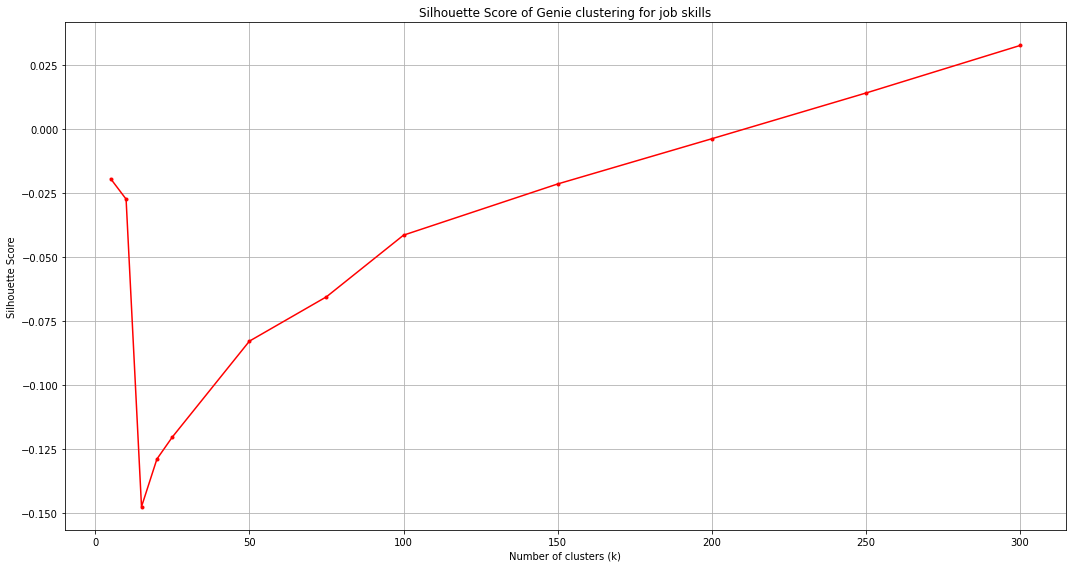

In [17]:
# Create plot
fig = plt.figure(figsize=(15, 8))
plt.plot(k_range, tuning_result["silhouette"], "r.-")
plt.title("Silhouette Score of Genie clustering for job skills")
plt.xlabel("Number of clusters (k)")
# plt.xticks(np.unique(tuning_result['n_clusters']))
plt.ylabel("Silhouette Score")
plt.grid()
plt.tight_layout()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "genie/" + "skill_genie_silhouette_plot.png",
    #     bbox_inches="tight",
    #     dpi=150,
)

# Show plot
plt.show()

#### Calinski Harabasz Score

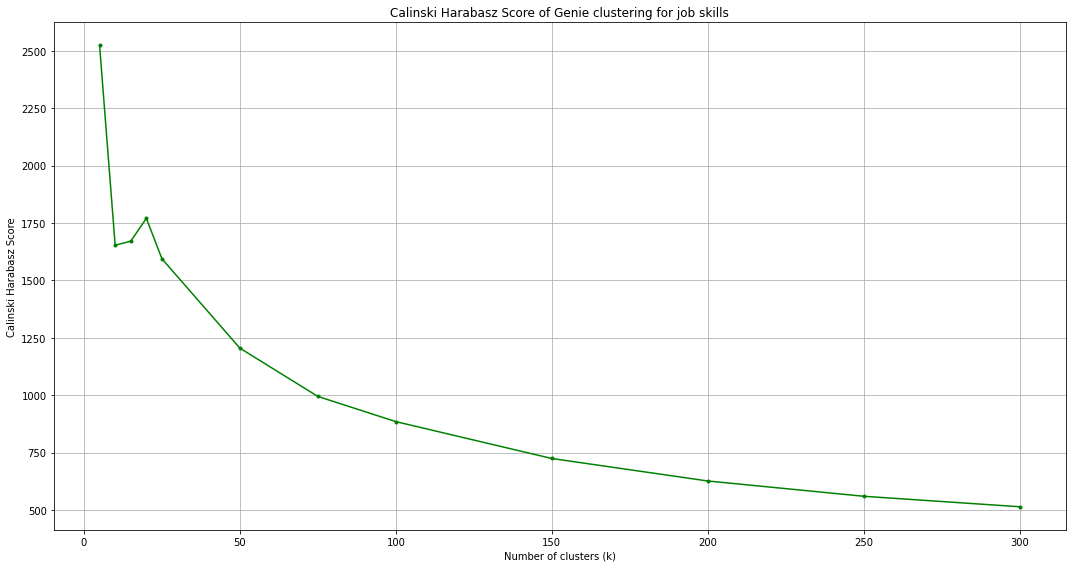

In [18]:
# Create plot
fig = plt.figure(figsize=(15, 8))
plt.plot(k_range, tuning_result["calinski_harabasz"], "g.-")
plt.title("Calinski Harabasz Score of Genie clustering for job skills")
plt.xlabel("Number of clusters (k)")
# plt.xticks(np.unique(tuning_result['n_clusters']))
plt.ylabel("Calinski Harabasz Score")
plt.grid()
plt.tight_layout()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "genie/" + "skill_genie_calinski_harabasz_plot.png",
    #     bbox_inches="tight",
    #     dpi=150,
)

# Show plot
plt.show()

#### Davies-Bouldin Score

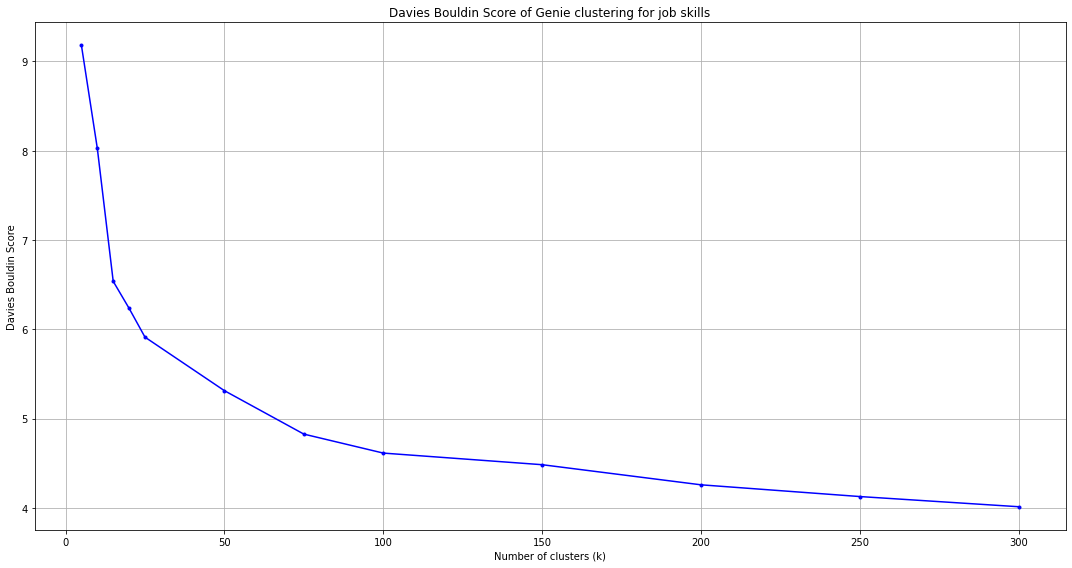

In [19]:
# Create plot
fig = plt.figure(figsize=(15, 8))
plt.plot(k_range, tuning_result["davies_bouldin"], "b.-")
plt.title("Davies Bouldin Score of Genie clustering for job skills")
plt.xlabel("Number of clusters (k)")
# plt.xticks(np.unique(tuning_result['n_clusters']))
plt.ylabel("Davies Bouldin Score")
plt.grid()
plt.tight_layout()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "genie/" + "skill_genie_davies_bouldin_plot.png",
    #     bbox_inches="tight",
    #     dpi=150,
)

# Show plot
plt.show()

## Visualize clusters

In [20]:
best_index = np.argmax(tuning_result['silhouette'])
# best_index = int(np.where(np.array(tuning_result['n_clusters']) == 20)[0])
print('Index of best model =', best_index)

best_k = tuning_result['n_clusters'][best_index]
print(f'Optimal number of clusters (k) = {best_k}')

best_labels = label_list[best_index]

Index of best model = 11
Optimal number of clusters (k) = 300


In [21]:
pca_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_pca_datapoints.npy")
umap_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_umap_datapoints.npy")
tsne_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_tsne_datapoints.npy")

Start PCA 2021-05-19 07:36:37.447044
End PCA 2021-05-19 07:36:37.483095
PCA duration 0:00:00.036051

Start t-SNE 2021-05-19 07:36:37.483095
End t-SNE 2021-05-19 07:36:37.508044
t-SNE duration 0:00:00.024949

Start UMAP 2021-05-19 07:36:37.509093
End UMAP 2021-05-19 07:36:37.534093
UMAP duration 0:00:00.025000



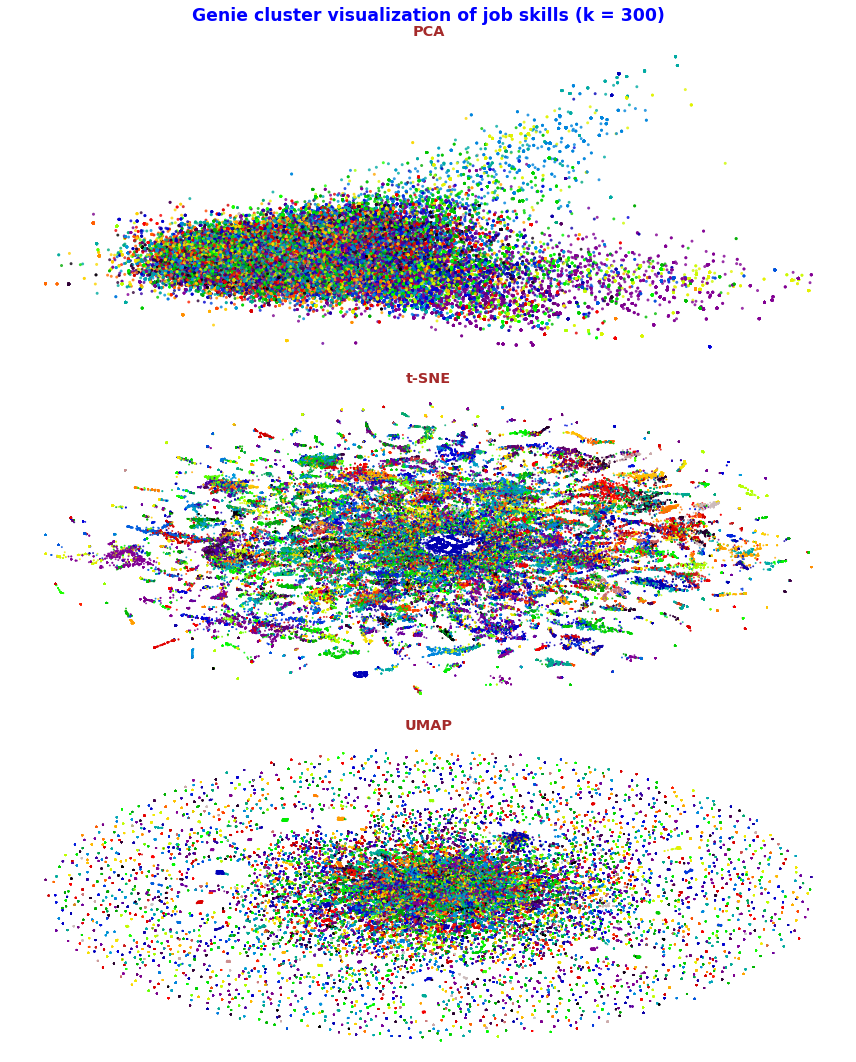

In [22]:
plot_title = f"Genie cluster visualization of job skills (k = {best_k})"
plot_filename = (
    RESULT_DIR + "genie/" + "skill_genie_optimal-cluster-visualization.png"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
# colors = cm.nipy_spectral(best_labels.astype(float) / best_k)
colors = best_labels

# Visualize clusters with PCA, UMAP, and t-SNE
visualize_cluster(
    plot_title,
    (12, 15),
    colors,
    palette,
    4,
    pca_datapoint,
    tsne_datapoint,
    umap_datapoint,
    pca=True,
    tsne=True,
    compute_umap=True,
    save_plots=True,
    plot_file=plot_filename,
)

## Display top words of each cluster

In [23]:
df_clusters = skill_docs.copy(deep=True)
df_clusters["model_type"] = "genie"
df_clusters["skill_n_clusters"] = best_k
df_clusters['skill_cluster_label'] = best_labels
df_clusters

,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token,model_type,skill_n_clusters,skill_cluster_label
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]",genie,300,0
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]",genie,300,1
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]",genie,300,2
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]",genie,300,3
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]",genie,300,4
...,...,...,...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]",genie,300,75
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]",genie,300,33
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]",genie,300,21
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]",genie,300,299


In [24]:
wordcount = {}
sorted_wordcount = {}
for i in range(best_k):
    skills = df_clusters[df_clusters["skill_cluster_label"] == i]["skill"].values
    skills = " ".join(" ".join(skills).split())
    wordcount[i] = {}
    for j in skills.split():
        if j in wordcount[i]:
            wordcount[i][j] += 1
        else:
            wordcount[i][j] = 1
    sorted_wordcount[i] = sorted(wordcount[i].items(), key=lambda x: x[1], reverse=True)

In [25]:
# tmp = df_clusters.copy(deep=True)
# tmp = tmp.loc[tmp['skill_cluster_label'] == 24]
# tmp.iloc[50:100, ]

In [26]:
topwords = {}
for key, i in sorted_wordcount.items():
    print("Cluster " + str(key) + ": ", end="")
    topwords[key] = ""
    n = 0
    for newkey, j in sorted_wordcount[key][:10]:
        print(newkey + "|", end="")
        topwords[key] = topwords[key] + newkey + "|"
        if n == 10:
            print("\n------------ ", end="")
        n += 1
    print()

Cluster 0: experience|skills|work|language|unprovided|english|team|financial|degree|development|
Cluster 1: skills|experience|work|communication|unprovided|software|excellent|strong|development|team|
Cluster 2: skills|work|software|unprovided|development|knowledge|experience|related|technical|communication|
Cluster 3: skills|experience|development|work|good|excellent|software|management|communication|unprovided|
Cluster 4: skills|management|work|experience|communication|excellent|unprovided|good|language|technical|
Cluster 5: skills|experience|work|development|good|software|excellent|communication|management|knowledge|
Cluster 6: skills|good|experience|unprovided|development|software|team|work|strong|communication|
Cluster 7: skills|experience|work|software|development|team|good|communication|unprovided|management|
Cluster 8: skills|work|software|good|team|management|experience|unprovided|development|technical|
Cluster 9: skills|experience|work|communication|unprovided|excellent|financ

In [27]:
topwords2 = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords2[key] = ''
    for newkey, j in sorted_wordcount[key][10:20]:
        print(newkey + '|', end='')
        topwords2[key] = topwords2[key] + newkey + '|'
    print()

Cluster 0: professional|business|project|university|software|services|communication|relevant|good|excellent|
Cluster 1: english|good|customer|related|technical|language|knowledge|languages|russian|office|
Cluster 2: team|good|customer|management|provide|develop|sales|english|strong|business|
Cluster 3: business|related|relevant|computer|position|financial|team|degree|office|technical|
Cluster 4: languages|higher|english|international|strong|team|education|financial|office|development|
Cluster 5: technical|strong|computer|provide|relevant|business|english|unprovided|team|related|
Cluster 6: knowledge|technical|office|working|management|excellent|position|financial|project|related|
Cluster 7: knowledge|degree|responsible|office|project|university|strong|excellent|relevant|language|
Cluster 8: degree|provide|communication|university|excellent|computer|new|project|activities|support|
Cluster 9: office|development|languages|strong|management|relevant|working|responsible|business|technical|


In [28]:
topwords3 = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords3[key] = ''
    for newkey, j in sorted_wordcount[key][20:30]:
        print(newkey + '|', end='')
        topwords3[key] = topwords3[key] + newkey + '|'
    print()

Cluster 0: management|education|technical|prepare|manage|knowledge|higher|web|provide|system|
Cluster 1: test|management|develop|university|system|relevant|financial|web|maintain|business|
Cluster 2: relevant|project|position|support|design|web|language|degree|computer|test|
Cluster 3: knowledge|maintain|web|working|activities|including|field|strong|languages|university|
Cluster 4: software|sales|degree|russian|system|related|tools|analysis|relevant|university|
Cluster 5: project|language|degree|languages|web|financial|education|office|new|university|
Cluster 6: computer|ms|information|seeking|services|design|support|systems|network|system|
Cluster 7: related|provide|technical|english|working|data|web|business|reports|ms|
Cluster 8: develop|strong|language|seeking|business|web|related|design|english|office|
Cluster 9: project|accounting|customer|maintain|reports|new|english|language|field|team|
Cluster 10: business|english|computer|project|new|support|web|systems|system|services|
Clust

## Save cluster results to file

In [29]:
df_clusters.to_csv(
    RESULT_DIR + "genie/" + "skill_genie_optimal-cluster-labels.csv", index=False
)

In [30]:
# Save tuple of model sets
pickle.dump(
    (sorted_wordcount, topwords, topwords2, topwords3),
    open(RESULT_DIR + "genie/" + "skill_genie_optimal-topwords.pkl", "wb"),
)